# Imports

In [1]:
import numpy as np
import pandas as pd
import json
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Functions

In [2]:
def exponential(x, a, b):
    return a * np.exp(b * x)

# Data

In [3]:
df_regions = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')

# Exponential fit italian regions

In [4]:
df_regions[df_regions.codice_regione == 20].head()

,codice_regione,data,deceduti,denominazione_regione,dimessi_guariti,isolamento_domiciliare,lat,long,nuovi_attualmente_positivi,ricoverati_con_sintomi,stato,tamponi,terapia_intensiva,totale_attualmente_positivi,totale_casi,totale_ospedalizzati
14,20,2020-02-24 18:00:00,0,Sardegna,0,0,39.215312,9.110616,0,0,ITA,1,0,0,0,0
35,20,2020-02-25 18:00:00,0,Sardegna,0,0,39.215312,9.110616,0,0,ITA,1,0,0,0,0
56,20,2020-02-26 18:00:00,0,Sardegna,0,0,39.215312,9.110616,0,0,ITA,1,0,0,0,0
77,20,2020-02-27 18:00:00,0,Sardegna,0,0,39.215312,9.110616,0,0,ITA,1,0,0,0,0
98,20,2020-02-28 18:00:00,0,Sardegna,0,0,39.215312,9.110616,0,0,ITA,1,0,0,0,0


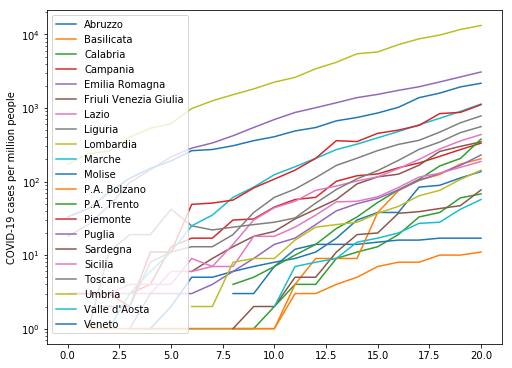

In [21]:
fig, ax = plt.subplots(figsize=(7,5), constrained_layout=True)

denominazioni = np.unique(df_regions.denominazione_regione.values)

for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    y = dfr.totale_casi.values
    days = len(y)
    y = y[y > 0]
    delta = days - len(y)
    x = np.arange(delta, days)
    ax.plot(x, y, label=den)
    
ax.set_yscale('log')
ax.set_ylabel('COVID-19 cases per million people')
ax.legend()

In [9]:
print(denominazioni)

['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'P.A. Bolzano' 'P.A. Trento' 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia'
 'Toscana' 'Umbria' "Valle d'Aosta" 'Veneto']
